In [15]:
!pip install pandas

In [16]:
!pip install requests

In [17]:
import requests
import pandas as pd

load_url = "https://api-v3.thaiwater.net/api/v1/thaiwater30/public/waterlevel_load"
headers = {"User-Agent": "Mozilla/5.0", "Accept": "application/json"}

payload = requests.get(load_url, headers=headers, timeout=30).json()

stations = payload["waterlevel_data"]["data"]
df_stations = pd.json_normalize(stations)

# Keep only what we need
cols = ["id", "station_type", "station.tele_station_name.th"]
keep = [c for c in cols if c in df_stations.columns]
df_stations = df_stations[keep].drop_duplicates()

print(df_stations.head())
df_stations.to_csv("thaiwater_station_list.csv", index=False, encoding="utf-8-sig")
print("Saved thaiwater_station_list.csv, rows:", len(df_stations))

           id     station_type station.tele_station_name.th
0  1203439728  tele_waterlevel              บ้านขนงพระเหนือ
1  1203496490  tele_waterlevel   สะพานธรรมจักร(วัดธรรมามูล)
2  1203496840  tele_waterlevel                        ปากรอ
3  1203496299  tele_waterlevel           สะพานแม่น้ำแควใหญ่
4  1203496463  tele_waterlevel                    คลองชะอวด
Saved thaiwater_station_list.csv, rows: 733


In [18]:
import re
import requests
import pandas as pd
from time import sleep

LOAD_URL = "https://api-v3.thaiwater.net/api/v1/thaiwater30/public/waterlevel_load"
GRAPH_URL = "https://api-v3.thaiwater.net/api/v1/thaiwater30/public/waterlevel_graph_year"
HEADERS = {"User-Agent": "Mozilla/5.0", "Accept": "application/json"}

YEARS = range(2024, 2027)   # keep small while testing
N = 5                       # run only first N stations


def looks_numeric(x) -> bool:
    if x is None:
        return False
    s = str(x).strip()
    return bool(re.fullmatch(r"\d{4,}", s))  # 4+ digits


# 1) Load station list
payload = requests.get(LOAD_URL, headers=HEADERS, timeout=30).json()
stations = payload["waterlevel_data"]["data"]
df_stations = pd.json_normalize(stations)

# 2) Find candidate numeric columns (station.* and top-level)
candidates = []
for c in df_stations.columns:
    if "name" in c.lower():
        continue
    sample = df_stations[c].dropna().astype(str).head(30)
    if len(sample) and any(looks_numeric(v) for v in sample):
        candidates.append(c)

print("Numeric-looking columns:", candidates)

# 3) Pick a station_type that supports graph endpoint (tele_waterlevel is known to work)
# Filter to tele_waterlevel rows if available
df_probe = df_stations[df_stations["station_type"] == "tele_waterlevel"].copy()
if df_probe.empty:
    df_probe = df_stations.copy()

if "station_type" in df_probe.columns:
    df_tele = df_probe[df_probe["station_type"] == "tele_waterlevel"].copy()
    if not df_tele.empty:
        df_probe = df_tele

if df_probe.empty:
    raise RuntimeError("Station list is empty (waterlevel_load returned no stations).")

probe_row = df_probe.iloc[0]
probe_station_type = probe_row.get("station_type", "tele_waterlevel") 

def test_candidate(col: str):
    v = probe_row.get(col)
    if not looks_numeric(v):
        return None

    station_id = str(v).strip()
    params = {"station_type": probe_station_type, "station_id": station_id, "year": "2026"}

    r = requests.get(GRAPH_URL, params=params, headers=HEADERS, timeout=30)
    if r.status_code != 200:
        return None

    try:
        j = r.json()
    except Exception:
        return None

    if j.get("result") == "OK" and j.get("data", {}).get("graph_data"):
        return station_id
    return None

graph_id_col = None
for col in candidates:
    ok_id = test_candidate(col)
    if ok_id:
        graph_id_col = col
        print("✅ Found graph station id column:", graph_id_col, "example:", ok_id)
        break

if not graph_id_col:
    raise RuntimeError(
        "Could not auto-detect the graph station id column.\n"
        "Please print `candidates` and show df_stations.head(1).to_dict()"
    )

# 4) Build run list (tele_waterlevel only is safest)
df_run = df_stations[df_stations["station_type"] == "tele_waterlevel"].copy()
df_run = df_run[df_run[graph_id_col].apply(looks_numeric)].copy()
df_run = df_run.head(N)

print(f"\nRunning first {len(df_run)} stations using {graph_id_col}")

all_rows = []

for i, (_, row) in enumerate(df_run.iterrows(), start=1):
    station_type = row["station_type"]
    station_id = str(row[graph_id_col]).strip()
    station_name = row.get("station.tele_station_name.th", row.get("station_name", ""))

    print(f"\n[{i}/{len(df_run)}] station_id={station_id} name={station_name}")

    for year in YEARS:
        params = {"station_type": station_type, "station_id": station_id, "year": str(year)}
        r = requests.get(GRAPH_URL, params=params, headers=HEADERS, timeout=30)

        if r.status_code != 200:
            print(" year", year, "status", r.status_code)
            continue

        p = r.json()
        gd = p.get("data", {}).get("graph_data", [])
        if not gd:
            continue

        year_entry = next((x for x in gd if str(x.get("year")) == str(year)), None)
        if not year_entry or not year_entry.get("data"):
            continue

        df = pd.DataFrame(year_entry["data"])
        if df.empty:
            continue

        df["ds"] = pd.to_datetime(df["datetime"], errors="coerce")

        # prefer waterlevel_msl, fallback waterlevel_m
        if "waterlevel_msl" in df.columns and df["waterlevel_msl"].notna().any():
            df["y"] = pd.to_numeric(df["waterlevel_msl"], errors="coerce")
        else:
            df["y"] = pd.to_numeric(df.get("waterlevel_m"), errors="coerce")

        df["station_id"] = station_id
        df["station_type"] = station_type
        df["station_name_th"] = station_name
        df["year"] = year

        df = df.dropna(subset=["ds", "y"])

        if not df.empty:
            all_rows.append(df[["station_id", "station_type", "station_name_th", "ds", "y", "year"]])

        sleep(0.1)

if not all_rows:
    raise RuntimeError("No data collected. Try changing YEARS or N.")

ts_all = pd.concat(all_rows, ignore_index=True).sort_values(["station_id", "ds"]).reset_index(drop=True)
out = f"thaiwater_first_{len(df_run)}_stations_history.csv"
ts_all.to_csv(out, index=False, encoding="utf-8-sig")
print("\nSaved:", out, "rows:", len(ts_all))


Numeric-looking columns: ['id', 'station.id', 'station.geocode_id']
✅ Found graph station id column: station.id example: 1117894

Running first 5 stations using station.id

[1/5] station_id=1117894 name=บ้านขนงพระเหนือ

[2/5] station_id=1121258 name=สะพานแม่น้ำแควใหญ่

[3/5] station_id=1093079 name=คลองชะอวด

[4/5] station_id=1109526 name=สะพานข้ามคลองอู่ตะเภา

[5/5] station_id=2575 name=ประปายโสธร

Saved: thaiwater_first_5_stations_history.csv rows: 3454


In [19]:
import pandas as pd

path = "thaiwater_first_5_stations_history.csv"
df = pd.read_csv(path)

df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values(["station_id", "ds"]).reset_index(drop=True)

print(df.head())
print(df.dtypes)
print("stations:", df["station_id"].nunique())
print(df["station_id"].unique()[:10])

   station_id     station_type station_name_th                  ds       y  \
0        2575  tele_waterlevel      ประปายโสธร 2024-01-01 06:00:00  124.27   
1        2575  tele_waterlevel      ประปายโสธร 2024-01-02 06:00:00  124.18   
2        2575  tele_waterlevel      ประปายโสธร 2024-01-03 06:00:00  124.18   
3        2575  tele_waterlevel      ประปายโสธร 2024-01-04 06:00:00  124.04   
4        2575  tele_waterlevel      ประปายโสธร 2024-01-05 06:00:00  123.92   

   year  
0  2024  
1  2024  
2  2024  
3  2024  
4  2024  
station_id                  int64
station_type                  str
station_name_th               str
ds                 datetime64[us]
y                         float64
year                        int64
dtype: object
stations: 5
[   2575 1093079 1109526 1117894 1121258]


In [20]:
station_id = df["station_id"].iloc[0]  # pick first
df1 = df[df["station_id"] == station_id].copy()

df1 = df1[["ds", "y"]].dropna()
df1 = df1.sort_values("ds")

print("station:", station_id, "rows:", len(df1))
df1.head()

station: 2575 rows: 735


,ds,y
0,2024-01-01 06:00:00,124.27
1,2024-01-02 06:00:00,124.18
2,2024-01-03 06:00:00,124.18
3,2024-01-04 06:00:00,124.04
4,2024-01-05 06:00:00,123.92


In [21]:
# Use date only (daily)
ts = df1.copy()
ts["date"] = ts["ds"].dt.floor("D")
ts = ts.groupby("date", as_index=False)["y"].mean()

ts = ts.set_index("date").asfreq("D")
# Fill missing values (simple interpolation)
ts["y"] = ts["y"].interpolate(limit_direction="both")

ts.head(), ts.tail()

(                 y
 date              
 2024-01-01  124.27
 2024-01-02  124.18
 2024-01-03  124.18
 2024-01-04  124.04
 2024-01-05  123.92,
                  y
 date              
 2026-02-07  125.10
 2026-02-08  125.09
 2026-02-09  125.14
 2026-02-10  125.14
 2026-02-11  125.13)

In [22]:
def make_features(ts_df):
    x = ts_df.copy()
    x["lag_1"]  = x["y"].shift(1)
    x["lag_2"]  = x["y"].shift(2)
    x["lag_3"]  = x["y"].shift(3)
    x["lag_7"]  = x["y"].shift(7)
    x["lag_14"] = x["y"].shift(14)

    x["roll_7_mean"]  = x["y"].shift(1).rolling(7).mean()
    x["roll_14_mean"] = x["y"].shift(1).rolling(14).mean()

    # Optional calendar features
    x["dow"] = x.index.dayofweek
    x["month"] = x.index.month
    return x

feat = make_features(ts)
feat = feat.dropna()

X = feat.drop(columns=["y"])
y = feat["y"]

X.head(), y.head()

(             lag_1   lag_2   lag_3   lag_7  lag_14  roll_7_mean  roll_14_mean  \
 date                                                                            
 2024-01-15  123.95  123.90  123.78  123.77  124.27   123.755714    123.884286   
 2024-01-16  123.98  123.95  123.90  123.56  124.18   123.785714    123.863571   
 2024-01-17  124.01  123.98  123.95  123.65  124.18   123.850000    123.851429   
 2024-01-18  123.99  124.01  123.98  123.68  124.04   123.898571    123.837857   
 2024-01-19  124.06  123.99  124.01  123.78  123.92   123.952857    123.839286   
 
             dow  month  
 date                    
 2024-01-15    0      1  
 2024-01-16    1      1  
 2024-01-17    2      1  
 2024-01-18    3      1  
 2024-01-19    4      1  ,
 date
 2024-01-15    123.98
 2024-01-16    124.01
 2024-01-17    123.99
 2024-01-18    124.06
 2024-01-19    124.04
 Freq: D, Name: y, dtype: float64)

In [24]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 403.6 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/8.1 MB 403.6 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/8.1 MB 403.6 kB/s eta 0:00:19
   --- ------------------------------------ 0.8/8.1 MB 447.7 kB/s eta 0:00:17
   --- ------------------------------------ 0.8/8.1 MB 447.7 kB/s eta 0:00:17
   ----- ---------------------------------- 1.0/8.1 MB 493

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

split_date = feat.index.max() - pd.Timedelta(days=60)  # last 60 days as test
train = feat[feat.index <= split_date]
test  = feat[feat.index >  split_date]

X_train, y_train = train.drop(columns=["y"]), train["y"]
X_test, y_test   = test.drop(columns=["y"]),  test["y"]

model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.09934303333330353


In [26]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   -------------------------------

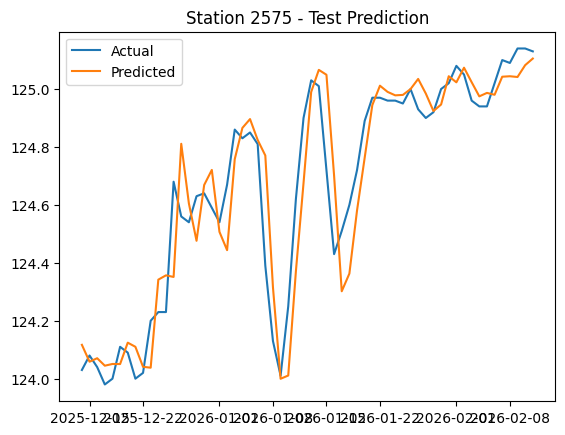

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, pred, label="Predicted")
plt.title(f"Station {station_id} - Test Prediction")
plt.legend()
plt.show()

In [28]:
import numpy as np

def forecast_next_days(ts_daily, model, days=7):
    ts_future = ts_daily.copy()

    for _ in range(days):
        feat = make_features(ts_future)[-1:]   # last row features
        feat = feat.drop(columns=["y"], errors="ignore")
        yhat = model.predict(feat)[0]

        next_day = ts_future.index.max() + pd.Timedelta(days=1)
        ts_future.loc[next_day, "y"] = yhat

    return ts_future

ts_forecasted = forecast_next_days(ts, model, days=7)

future_part = ts_forecasted.tail(7)
future_part

,y
date,
2026-02-12,125.10522
2026-02-13,125.12894
2026-02-14,125.09948
2026-02-15,125.10238
2026-02-16,125.08284
2026-02-17,125.09144
2026-02-18,125.07642
